In [ ]:
!pip install efficientnet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.7 MB/s eta 0:00:00


In [ ]:
# 1. IMPORTS & CONFIGURATION
import os
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm

import kagglehub
# from sklearn.metrics import confusion_matrix, cohen_kappa_score
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

import albumentations as A
warnings.filterwarnings("ignore")

In [ ]:
# 2. DOWNLOAD & LOAD DATASET
path = kagglehub.dataset_download("mariaherrerot/aptos2019")
train_data = pd.read_csv(os.path.join(path, "train_1.csv"))
valid_data = pd.read_csv(os.path.join(path, "valid.csv"))
test_data  = pd.read_csv(os.path.join(path, "test.csv"))

train_image_dir = "/kaggle/input/aptos2019/train_images/train_images"
val_image_dir = "/kaggle/input/aptos2019/val_images/val_images"
test_image_dir = "/kaggle/input/aptos2019/test_images/test_images"

class_labels = {0: "No DR", 1: "Mild", 2: "Moderate", 3: "Severe", 4: "Proliferative DR"}

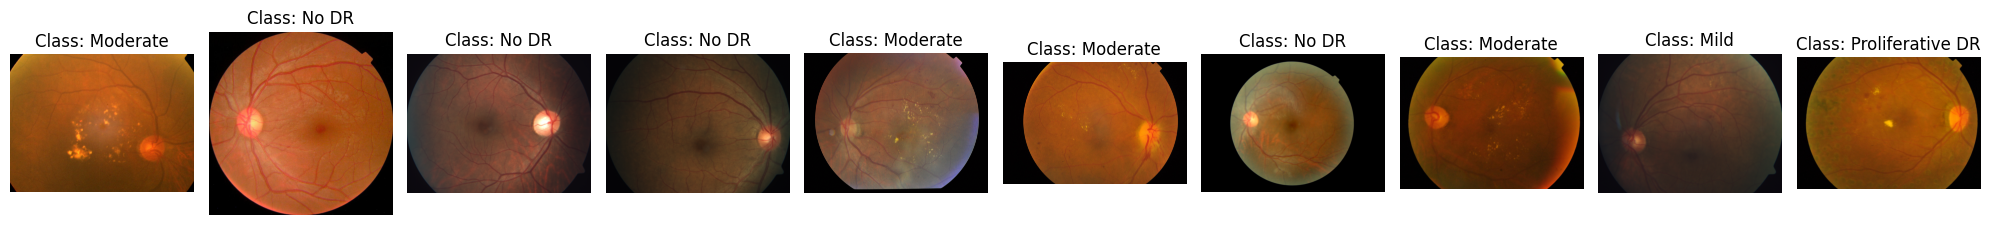

In [ ]:
# Check some random images from the training set to ensure they are correctly labeled
import matplotlib.image as mpimg
random_samples = random.sample(list(train_data['id_code']), 10)

plt.figure(figsize=(20, 10))
for i, image_id in enumerate(random_samples):
    # Image file path
    img_path = os.path.join(train_image_dir, f"{image_id}.png")  # Adjust extension if necessary
    img = mpimg.imread(img_path)

    # Get the class label for the image
    image_class = train_data.loc[train_data['id_code'] == image_id, 'diagnosis'].values[0]
    class_name = class_labels.get(image_class, "Unknown")

    # Plot the image
    plt.subplot(1, 10, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Class: {class_name}")

plt.tight_layout()
plt.show()

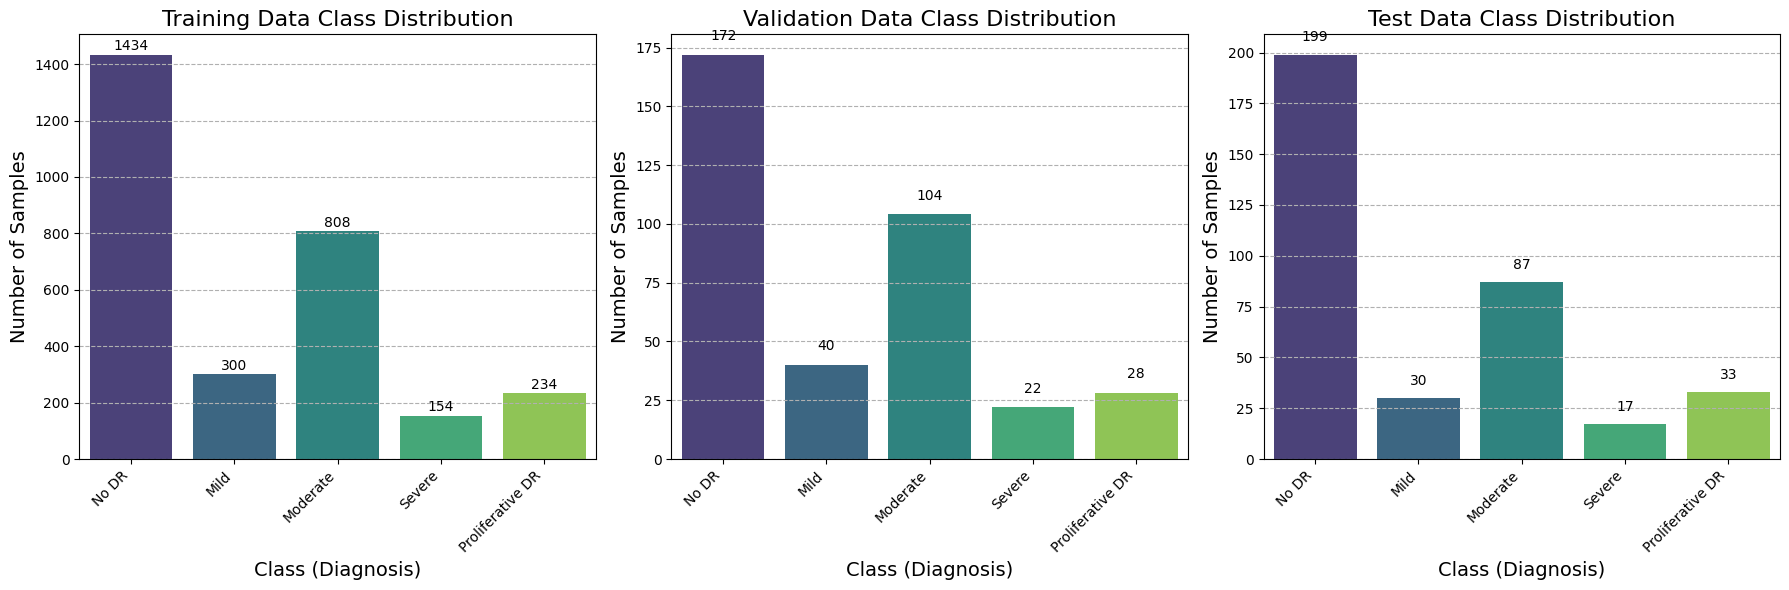

Training Data Class Distribution:
diagnosis
0    1434
1     300
2     808
3     154
4     234
Name: count, dtype: int64

Validation Data Class Distribution:
diagnosis
0    172
1     40
2    104
3     22
4     28
Name: count, dtype: int64

Test Data Class Distribution:
diagnosis
0    199
1     30
2     87
3     17
4     33
Name: count, dtype: int64


In [ ]:
# Count the occurrences of each class in the training, validation, and test datasets
train_class_counts = train_data['diagnosis'].value_counts().sort_index()
val_class_counts = valid_data['diagnosis'].value_counts().sort_index()
test_class_counts = test_data['diagnosis'].value_counts().sort_index()

# Set up the bar charts for each dataset
plt.figure(figsize=(18, 6))

# Function to add data labels to bars
def add_labels(ax, counts):
    for i, v in enumerate(counts.values):
        ax.text(i, v + 5, str(v), ha='center', va='bottom')

# Training Data
ax1 = plt.subplot(1, 3, 1)
sns.barplot(x=train_class_counts.index, y=train_class_counts.values, palette='viridis', ax=ax1)
plt.title('Training Data Class Distribution', fontsize=16)
plt.xlabel('Class (Diagnosis)', fontsize=14)
plt.ylabel('Number of Samples', fontsize=14)
plt.xticks(ticks=train_class_counts.index, labels=[class_labels[i] for i in train_class_counts.index], rotation=45, ha='right')
plt.grid(axis='y', linestyle='--')
add_labels(ax1, train_class_counts)

# Validation Data
ax2 = plt.subplot(1, 3, 2)
sns.barplot(x=val_class_counts.index, y=val_class_counts.values, palette='viridis', ax=ax2)
plt.title('Validation Data Class Distribution', fontsize=16)
plt.xlabel('Class (Diagnosis)', fontsize=14)
plt.ylabel('Number of Samples', fontsize=14)
plt.xticks(ticks=val_class_counts.index, labels=[class_labels[i] for i in val_class_counts.index], rotation=45, ha='right')
plt.grid(axis='y', linestyle='--')
add_labels(ax2, val_class_counts)

# Test Data
ax3 = plt.subplot(1, 3, 3)
sns.barplot(x=test_class_counts.index, y=test_class_counts.values, palette='viridis', ax=ax3)
plt.title('Test Data Class Distribution', fontsize=16)
plt.xlabel('Class (Diagnosis)', fontsize=14)
plt.ylabel('Number of Samples', fontsize=14)
plt.xticks(ticks=test_class_counts.index, labels=[class_labels[i] for i in test_class_counts.index], rotation=45, ha='right')
plt.grid(axis='y', linestyle='--')
add_labels(ax3, test_class_counts)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

# Print the number of samples for each class in the training data
print("Training Data Class Distribution:")
print(train_class_counts)
print("\nValidation Data Class Distribution:")
print(val_class_counts)
print("\nTest Data Class Distribution:")
print(test_class_counts)

In [ ]:
# 3. DEFINE ALBUMENTATIONS AUGMENTATIONS
IMG_SIZE = 224
NUM_CLASSES = 5

train_transform = A.Compose([
    A.RandomResizedCrop(size=(IMG_SIZE, IMG_SIZE), scale=(0.8, 1.0), p=1.0),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
    A.HueSaturationValue(p=0.3),
    A.OneOf([
        A.GaussianBlur(p=0.3),
        A.MotionBlur(p=0.3),
        A.GaussNoise(p=0.3),
    ], p=0.3),
])

In [ ]:
# 4. LOAD IMAGES WITH AUGMENTATION OPTION
def load_images(df, image_dir, ext=".png", augment=False):
    X, y = [], []
    for i in tqdm(range(len(df))):
        file_name = df.iloc[i]['id_code'] + ext
        label = df.iloc[i]['diagnosis']
        img_path = os.path.join(image_dir, file_name)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            if augment:
                img = train_transform(image=img)["image"]
                img = img / 255.0
            else:
                img = img / 255.0
            X.append(img)
            y.append(label)
    return np.array(X), to_categorical(y, NUM_CLASSES)

X_train, y_train = load_images(train_data, train_image_dir, augment=True)
X_val, y_val     = load_images(valid_data, val_image_dir)
X_test, y_test   = load_images(test_data, test_image_dir)

100%|██████████| 366/366 [00:39<00:00,  9.30it/s]


In [ ]:
# 5. Building the model
from efficientnet.tfkeras import EfficientNetB5

base_model = EfficientNetB5(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

115515256/115515256 ━━━━━━━━━━━━━━━━━━━━ 10s 0us/step


In [ ]:
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation='softmax')
])

model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnet-b5 (Functional)    │ (None, 7, 7, 2048)     │    28,513,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    25,690,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,205,173 (206.78 MB)

 Trainable params: 54,032,437 (206.12 MB)

 Non-trainable params: 172,736 (674.75 KB)

In [ ]:
# 6. training the model
early_stop = EarlyStopping(patience=5, restore_best_weights=True)
lr_reduce = ReduceLROnPlateau(patience=3, factor=0.5, verbose=1)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size = 64,
    callbacks=[early_stop, lr_reduce]
)

Epoch 1/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 358s 4s/step - accuracy: 0.5357 - loss: 1.4294 - val_accuracy: 0.4836 - val_loss: 1.5278 - learning_rate: 1.0000e-04
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 105s 1s/step - accuracy: 0.7410 - loss: 0.7306 - val_accuracy: 0.6120 - val_loss: 1.1535 - learning_rate: 1.0000e-04
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.7628 - loss: 0.6398 - val_accuracy: 0.7049 - val_loss: 0.9998 - learning_rate: 1.0000e-04
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.8336 - loss: 0.4713 - val_accuracy: 0.7541 - val_loss: 0.7755 - learning_rate: 1.0000e-04
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.8566 - loss: 0.3891 - val_accuracy: 0.7404 - val_loss: 0.8478 - learning_rate: 1.0000e-04
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.8799 - loss: 0.3380 - val_accuracy: 0.7732 - val_loss: 0.7575 - learning_rate: 1.0000e-04
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.9184 - los

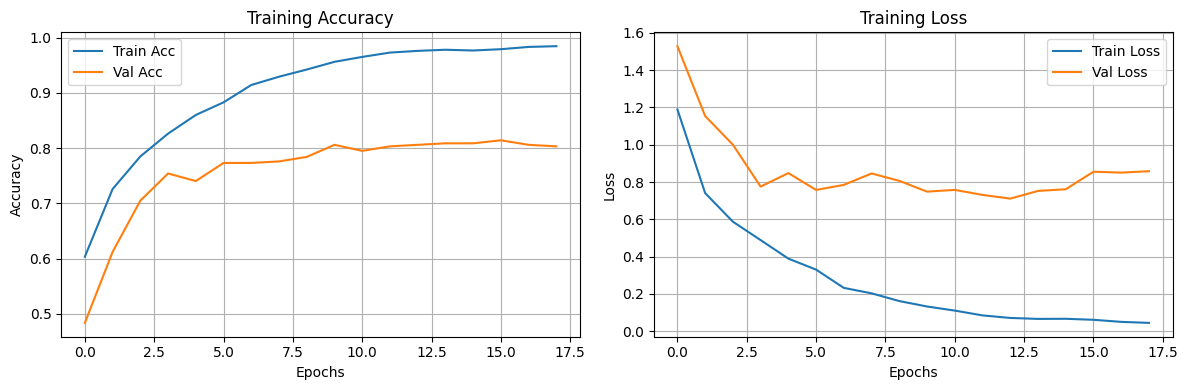

In [ ]:
# 7. TRAINING PLOTS
plt.figure(figsize=(12, 4)) # Adjust the figure size to accommodate two plots side-by-side
plt.subplot(1, 2, 1) # 1 row, 2 columns, first plot
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Training Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2) # 1 row, 2 columns, second plot
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.tight_layout() # Adjust layout to prevent overlapping titles/labels
plt.show()

In [ ]:
# 8. EVALUATION
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {acc * 100:.2f}%")

Test Accuracy: 80.05%


In [ ]:
# 9. PREDICT RANDOM IMAGE
def predict_random_image(test_df, image_dir, model, class_labels, img_size=224):
    row = test_df.sample(n=1).iloc[0]
    img_id = row["id_code"]
    true_label = int(row["diagnosis"])
    img_path = os.path.join(image_dir, img_id + ".png")

    img = cv2.imread(img_path)
    img_resized = cv2.resize(img, (img_size, img_size))
    img_input = np.expand_dims(img_resized / 255.0, axis=0)

    preds = model.predict(img_input)
    pred_class = np.argmax(preds)

    plt.imshow(cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB))
    title = f"True: {class_labels[true_label]} | Predicted: {class_labels[pred_class]}"
    plt.title(title, color="green" if true_label == pred_class else "red")
    plt.axis("off")
    plt.show()

    print("Prediction probabilities:", preds[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


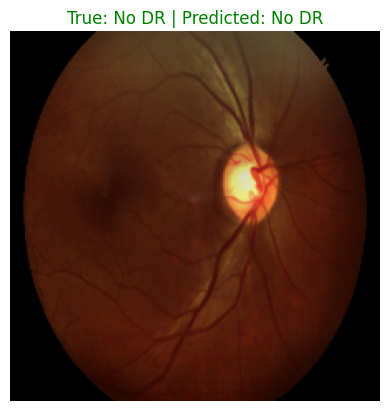

Prediction probabilities: [9.99999881e-01 1.14995302e-07 2.11924456e-09 1.00386276e-10
 2.47338761e-10]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


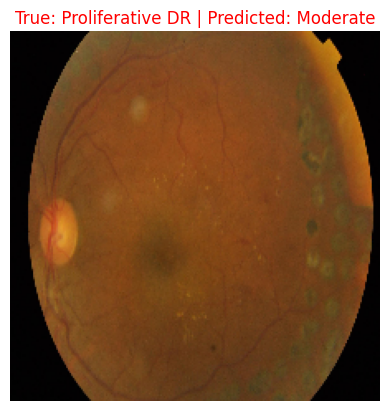

Prediction probabilities: [1.8250332e-05 5.5335823e-04 5.8021128e-01 9.0360291e-02 3.2885677e-01]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


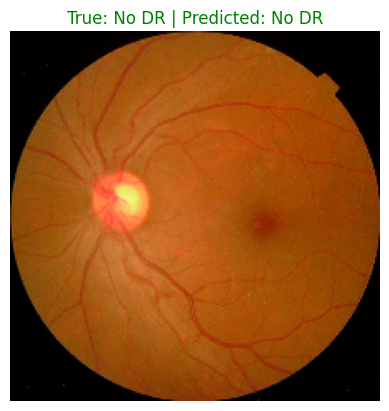

Prediction probabilities: [9.9945062e-01 1.8561761e-04 3.6276443e-04 8.8182389e-08 7.8100726e-07]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


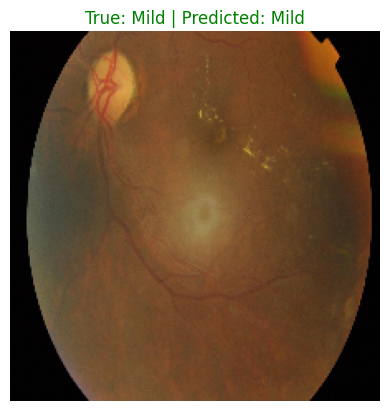

Prediction probabilities: [0.02315122 0.8557269  0.07289702 0.00105064 0.04717425]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


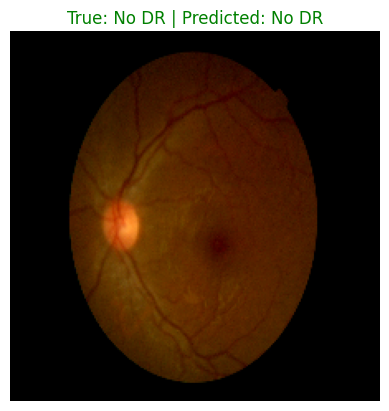

Prediction probabilities: [1.0000000e+00 8.1529911e-15 1.3401306e-14 2.2475854e-15 2.7396002e-16]


In [ ]:
for _ in range(5):
    predict_random_image(test_data, test_image_dir, model, class_labels)